# **Importing libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# **Load Dataset**

In [ ]:
data = pd.read_csv('/content/owid-covid-data.csv')

# **Display first few rows**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399296 entries, 0 to 399295
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   iso_code                                    399296 non-null  object 
 1   continent                                   380194 non-null  object 
 2   location                                    399296 non-null  object 
 3   date                                        399296 non-null  object 
 4   total_cases                                 360296 non-null  float64
 5   new_cases                                   388138 non-null  float64
 6   new_cases_smoothed                          386908 non-null  float64
 7   total_deaths                                337785 non-null  float64
 8   new_deaths                                  388495 non-null  float64
 9   new_deaths_smoothed                         387265 non-null  float64
 

In [ ]:
data.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-01-08,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-01-09,NaN,0.0,NaN,NaN,0.0,NaN,...,NaN,37.746,0.5,64.83,0.511,41128772.0,NaN,NaN,NaN,NaN


# **Data preprocessing**

**Filter data to keep only relevant columns and ensure 'total_cases' is present**

In [ ]:
data = data[['date', 'location', 'total_cases']]

**Handle missing values**

In [ ]:
data['total_cases'] = data['total_cases'].replace(0, np.nan).fillna(method='ffill').fillna(method='bfill')


**Filter out rows where 'total_cases' is still zero after filling**

In [ ]:
data = data[data['total_cases'] > 0]

**Focus on a specific country for detailed analysis**

In [ ]:
country = 'United States'
data_country = data[data['location'] == country]

In [ ]:
data_country['date'] = pd.to_datetime(data_country['date'])
data_pivoted = data_country.pivot_table(index='date', columns='location', values='total_cases', fill_value=0)


<ipython-input-11-a5d5bd219025>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_country['date'] = pd.to_datetime(data_country['date'])


# **Feature Engineering**

In [ ]:
data_rolling = data_pivoted.rolling(window=7).mean().fillna(0)
data_diff = data_pivoted.diff().fillna(0)
data_combined = pd.concat([data_pivoted, data_rolling, data_diff], axis=1)
data_combined.columns = [f"{col}_{suffix}" for col in data_pivoted.columns for suffix in ["original", "rolling", "diff"]]


**Ensure there are no NaN values**

In [ ]:
imputer = SimpleImputer(strategy='mean')
data_combined_imputed = pd.DataFrame(imputer.fit_transform(data_combined), columns=data_combined.columns)


**Creating supervised learning data**

In [ ]:
look_back = 7
X, y = [], []
for i in range(len(data_combined_imputed) - look_back):
    X.append(data_combined_imputed.iloc[i:i + look_back].values.flatten())
    y.append(data_pivoted.iloc[i + look_back].values)

X, y = np.array(X), np.array(y)

# **Split the data into training and testing sets**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **hyperparameters with RandomForestRegressor**

In [ ]:
model = RandomForestRegressor(n_estimators=150, max_depth=20, min_samples_split=5, min_samples_leaf=2, random_state=42)
model.fit(X_train, y_train)

<ipython-input-28-12a9f406212b>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=150, random_state=42)

# **Predict on the test set**

In [ ]:
y_pred = model.predict(X_test)

# **Evaluate the model**

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


In [ ]:
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 1438505786687.6074
R-squared: 0.9990775054178157


# **Predict future cases (next 30 days)**

In [ ]:
future_days = 30
last_days_data = data_combined_imputed.iloc[-look_back:].values.flatten().reshape(1, -1)
future_predictions = []
for _ in range(future_days):
    next_day_prediction = model.predict(last_days_data)
    future_predictions.append(next_day_prediction.flatten())
    last_days_data = np.roll(last_days_data, -data_combined_imputed.shape[1])
    last_days_data[0, -data_combined_imputed.shape[1]:] = np.concatenate([next_day_prediction.flatten(),
                                                                         next_day_prediction.flatten(),
                                                                         next_day_prediction.flatten()])

**Convert predictions to DataFrame**

In [ ]:
future_predictions_df = pd.DataFrame(future_predictions, columns=data_pivoted.columns)

# **Print detailed future predictions**

In [ ]:
print("Future COVID-19 Case Predictions (Next 30 Days):")
print(future_predictions_df)


Future COVID-19 Case Predictions (Next 30 Days):
location  United States
0          1.034368e+08
1          1.034368e+08
2          1.034368e+08
3          1.034368e+08
4          1.034361e+08
5          1.034361e+08
6          1.034361e+08
7          1.034361e+08
8          1.034361e+08
9          1.034361e+08
10         1.034361e+08
11         1.034361e+08
12         1.034361e+08
13         1.034361e+08
14         1.034361e+08
15         1.034361e+08
16         1.034361e+08
17         1.034361e+08
18         1.034361e+08
19         1.034361e+08
20         1.034361e+08
21         1.034361e+08
22         1.034361e+08
23         1.034361e+08
24         1.034361e+08
25         1.034361e+08
26         1.034361e+08
27         1.034361e+08
28         1.034361e+08
29         1.034361e+08


# **Visualization**

In [ ]:
sample_size = 100
indices = np.random.choice(len(y_test), sample_size, replace=False)
y_test_sample = y_test[indices]
y_pred_sample = y_pred[indices]


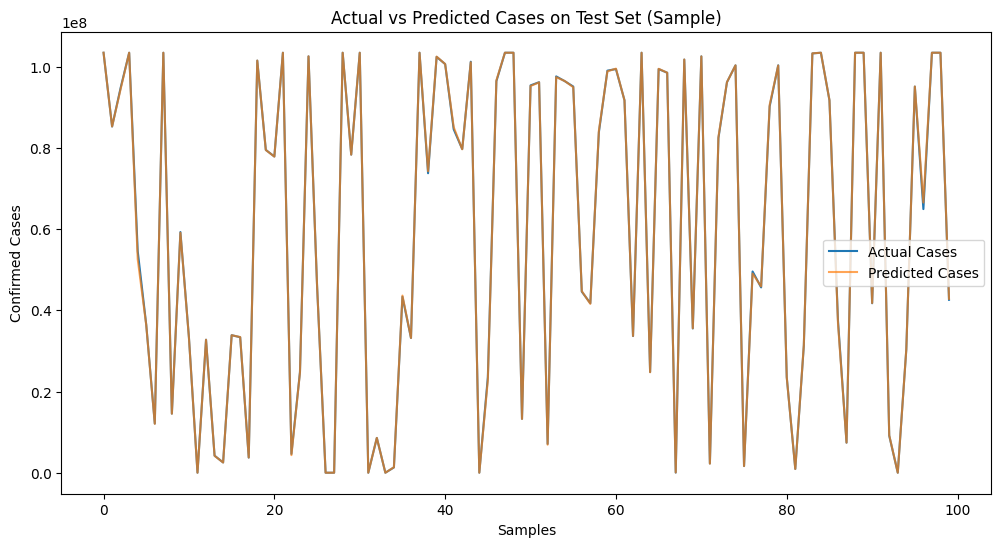

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_sample.flatten(), label='Actual Cases')
plt.plot(y_pred_sample.flatten(), label='Predicted Cases', alpha=0.7)
plt.xlabel('Samples')
plt.ylabel('Confirmed Cases')
plt.title('Actual vs Predicted Cases on Test Set (Sample)')
plt.legend()
plt.show()

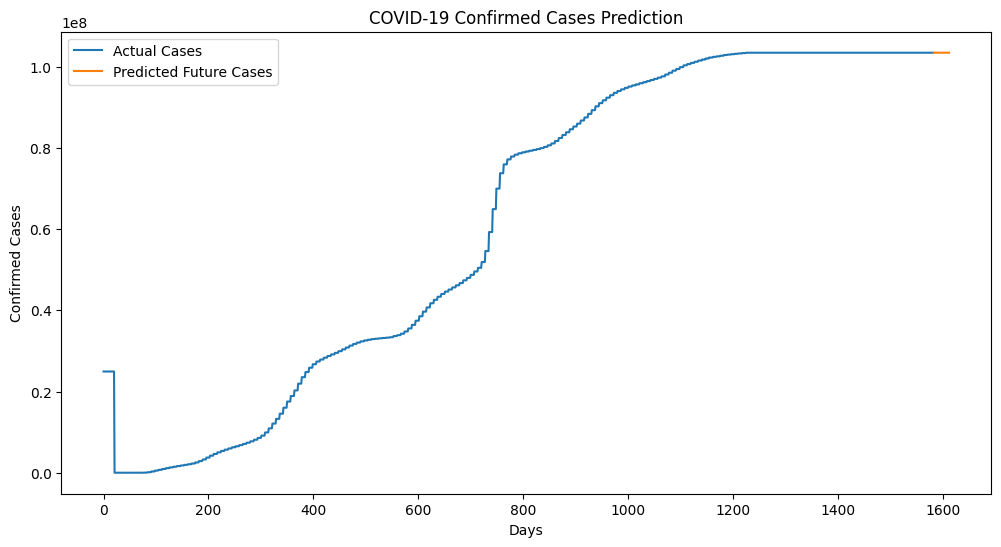

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(data_pivoted)), data_pivoted.iloc[:, -1], label='Actual Cases')
plt.plot(range(len(data_pivoted), len(data_pivoted) + future_days), future_predictions_df.iloc[:, -1], label='Predicted Future Cases')
plt.xlabel('Days')
plt.ylabel('Confirmed Cases')
plt.title('COVID-19 Confirmed Cases Prediction')
plt.legend()
plt.show()